# Visualize GCOM-C products

The `gportal` package also provides utilities for handling product files.

This example demonstrates the conversion into GeoTIFF and visualization of GCOM-C products.

The file utility dependencies are included as extras. Please install the `gcomc` extra.

```console
$ pip install gportal[gcomc]
```

In [1]:
import gportal
from gportal.file import GCOMCFile

import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import folium

In [2]:
%config InlineBackend.figure_formats = ['retina']

In [3]:
import getpass

gportal.username = "sankichi92"  # Replace with your username
gportal.password = getpass.getpass()

In [4]:
datasets = gportal.datasets()

## Sea Surface Temperature (L3 EQR)

Let's visualize a Sea Surface Temperature (SST) product.

This example uses the monthly average of SST for April 2023.  
（DOI: [`10.57746/EO.01gs73bk6wn2emvck9801r41qq`](https://doi.org/10.57746/EO.01gs73bk6wn2emvck9801r41qq)）

In [5]:
sst_res = gportal.search(
    dataset_ids=datasets["GCOM-C/SGLI"]["LEVEL3"]["Oceanic sphere"]["L3-SST"],
    start_time="2023-04-01T00:00:00Z",
    end_time="2023-04-30T23:59:59Z",
    params={
        "ProcessTimeUnit": "01M",
        "orbitDirection": "Ascending",
    },
)
sst_products = list(sst_res.products())
sst_products

[<gportal.Product id=GC1SG1_20230401A01M_X0000_3BSG_SST_F_3000>,
 <gportal.Product id=GC1SG1_20230401A01M_D0000_3MSG_SST_F_3000>]

There are two products. The difference is in the map projection.  
(Refer to https://shikisai.jaxa.jp/faq/faq0003.html for the file naming rule.)

In [6]:
[p["mapProjection"] for p in sst_products]

['EQA', 'EQR']

Here, use the EQR (equirectangular) projection.

In [7]:
sst_product = next((p for p in sst_products if p["mapProjection"] == "EQR"))

Download the product.

In [8]:
sst_path = gportal.download(sst_product, local_dir="./downloads")

Open the downloaded product as a `GCOMCFile` object.

In [9]:
sst_file = GCOMCFile.open(sst_path)
sst_file.image_data  # returns a dictionary of the data included in the file.

{'SST_AVE': <HDF5 dataset "SST_AVE": shape (4320, 8640), type "<u2">,
 'SST_QA_flag': <HDF5 dataset "SST_QA_flag": shape (4320, 8640), type "|u1">}

Save the `SST_AVE` data as a GeoTIFF file.

In [10]:
sst_geotiff = sst_file.save_as_geotiff(targets=["SST_AVE"], output_dir="./downloads")
sst_geotiff

{'SST_AVE': 'downloads/GC1SG1_20230401A01M_D0000_3MSG_SST_F_3000-SST_AVE.tif'}

Re-open the GeoTIFF file as a `xarray.DataArray` using [`rioxarray`](https://corteva.github.io/rioxarray/).

In [11]:
sst = rioxarray.open_rasterio(sst_geotiff["SST_AVE"], mask_and_scale=True)
print(sst)

<xarray.DataArray (band: 1, y: 4320, x: 8640)>
[37324800 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * y            (y) float64 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area


Let's call the `plot` method.

In [12]:
sst.plot()

Improve the figure (using [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/) to display the coastlines).

Text(0.5, 1.0, 'GC1SG1_20230401A01M_D0000_3MSG_SST_F_3000')

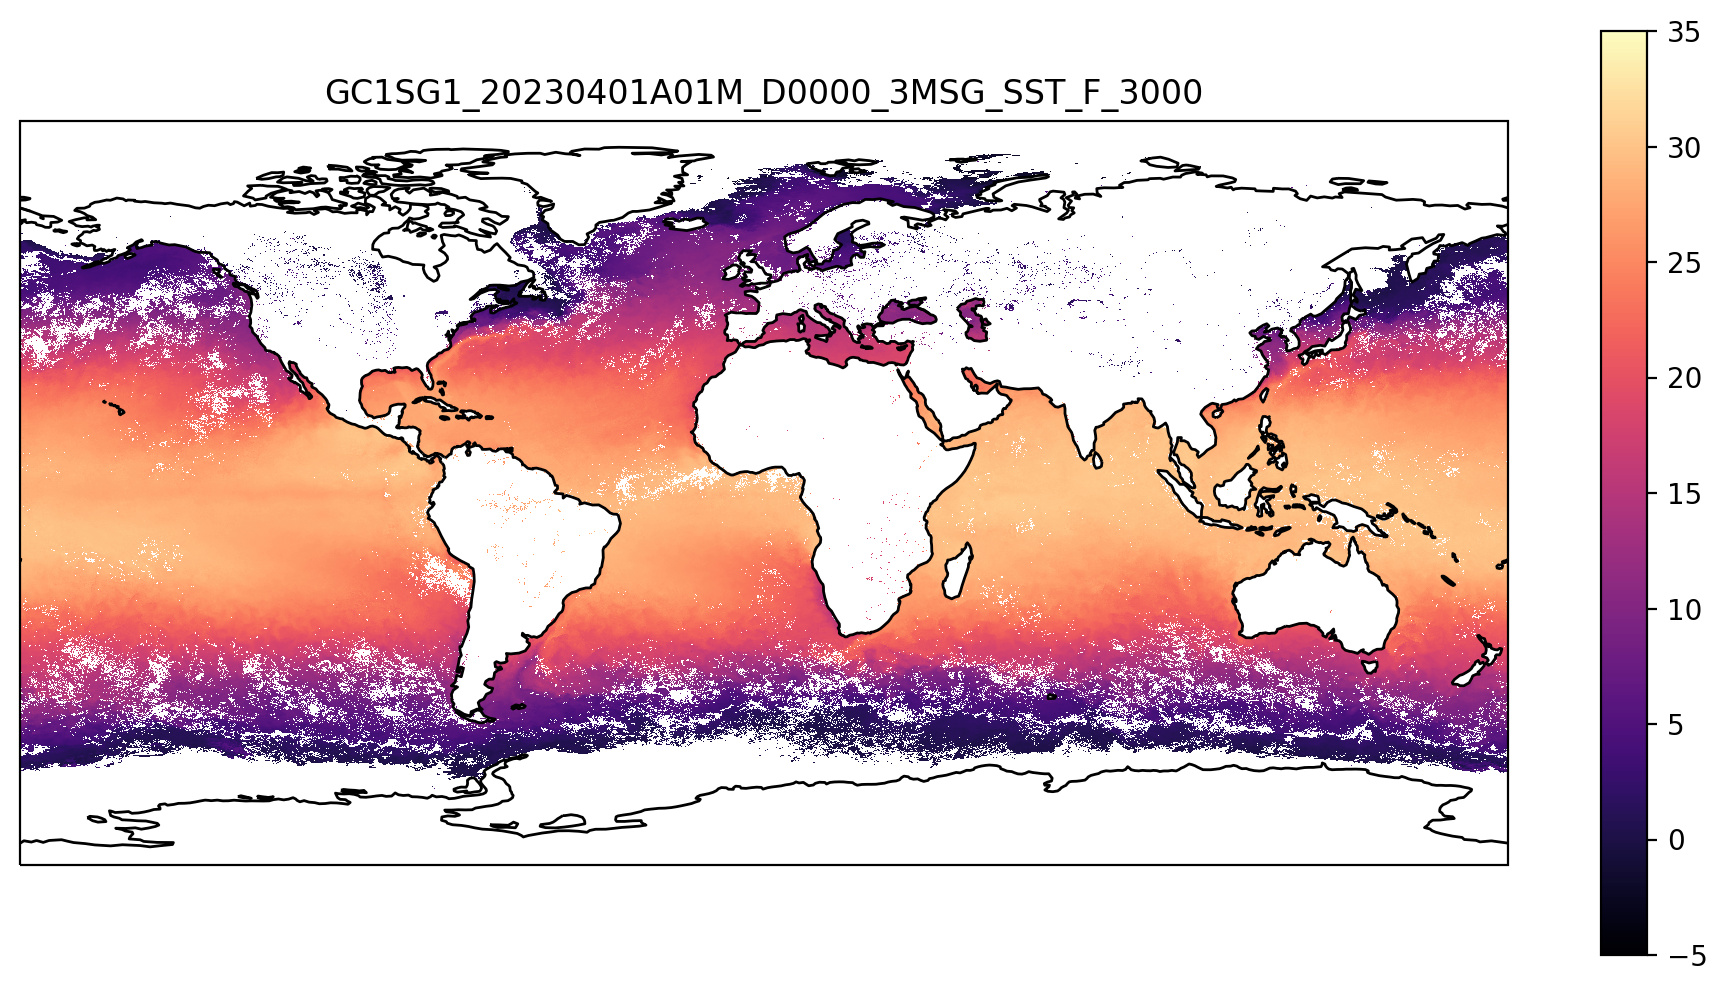

In [13]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
sst.plot(ax=ax, vmin=-5, vmax=35, cmap="magma")
ax.set_title(sst_file.granule_id)

## RGB image using Land Surface Reflectance (L2 Tile)

Let's display an RGB image using a Land Surface Reflectance (RSRF) product ([`10.57746/EO.01gs73b3q4r5j7qm7sfxsdh7jg`](https://doi.org/10.57746/EO.01gs73b3q4r5j7qm7sfxsdh7jg)).

Get the bbox of Tokyo from [GADM](https://gadm.org/download_country.html).

In [14]:
jpn_adm = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_JPN_2.json.zip")
tokyo_bbox = jpn_adm[jpn_adm["NAME_1"] == "Tokyo"].total_bounds
tokyo_bbox

array([138.8155,  24.2247, 153.9867,  35.8941])

Search for products that include Tokyo in April 2023.

In [15]:
rsrf_res = gportal.search(
    dataset_ids=datasets["GCOM-C/SGLI"]["LEVEL2"]["Land area"]["L2-RSRF"],
    bbox=tokyo_bbox,
    start_time="2023-04-01T00:00:00Z",
    end_time="2023-04-30T23:59:59Z",
)
rsrf_res.matched()

300

Explore the search results.

In [16]:
rsrf_gdf = gpd.GeoDataFrame.from_features(
    [p.to_dict(flatten_properties=True) for p in rsrf_res.products()], crs="EPSG:4326"
)
nunique = rsrf_gdf.nunique()
unique_cols = nunique[nunique > 1].index
rsrf_gdf = rsrf_gdf[unique_cols]

map = rsrf_gdf.explore("identifier", legend=False, style_kwds={"fillOpacity": 0.01})
folium.Rectangle(bounds=[(tokyo_bbox[1], tokyo_bbox[0]), (tokyo_bbox[3], tokyo_bbox[2])]).add_to(map)
map

Due to the inclusion of outlying islands, the bbox has become broader.  
The L2-RSRF products are organized into "tiles" of a certain size, and we only need the top-left one with a tileNo of 529.

Narrow down the search results by filtering for `tileNo=529` and `totalQualityCode=Good`.

In [17]:
filtered_rsrf_gdf = rsrf_gdf[(rsrf_gdf["tileNo"] == 529) & (rsrf_gdf["totalQualityCode"] == "Good")]
filtered_rsrf_gdf

geometry   
1    POLYGON ((143.59480 40.00000, 156.64888 40.000...  \
10   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
22   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
39   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
41   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
50   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
60   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
78   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
81   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
90   POLYGON ((143.59480 40.00000, 156.64888 40.000...   
102  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
115  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
121  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
132  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
142  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
156  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
161  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
172  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
189  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
191  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
201  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
212  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
230  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
231  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
242  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
252  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
266  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
271  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
283  POLYGON ((143.59480 40.00000, 156.64888 40.000...   
292  POLYGON ((143.59480 40.00000, 156.64888 40.000...   

                                    identifier           processingDate   
1    GC1SG1_20230401D01D_T0529_L2SG_RSRFQ_3002  2023-04-01T16:45:58.00Z  \
10   GC1SG1_20230402D01D_T0529_L2SG_RSRFQ_3002  2023-04-02T15:23:30.00Z   
22   GC1SG1_20230403D01D_T0529_L2SG_RSRFQ_3002  2023-04-03T15:28:10.00Z   
39   GC1SG1_20230404D01D_T0529_L2SG_RSRFQ_3002  2023-04-05T15:16:54.00Z   
41   GC1SG1_20230405D01D_T0529_L2SG_RSRFQ_3002  2023-04-05T17:01:04.00Z   
50   GC1SG1_20230406D01D_T0529_L2SG_RSRFQ_3002  2023-04-06T15:21:37.00Z   
60   GC1SG1_20230407D01D_T0529_L2SG_RSRFQ_3002  2023-04-07T15:45:18.00Z   
78   GC1SG1_20230408D01D_T0529_L2SG_RSRFQ_3002  2023-04-09T15:17:50.00Z   
81   GC1SG1_20230409D01D_T0529_L2SG_RSRFQ_3002  2023-04-09T16:53:07.00Z   
90   GC1SG1_20230410D01D_T0529_L2SG_RSRFQ_3002  2023-04-10T15:18:41.00Z   
102  GC1SG1_20230411D01D_T0529_L2SG_RSRFQ_3002  2023-04-11T15:19:09.00Z   
115  GC1SG1_20230412D01D_T0529_L2SG_RSRFQ_3002  2023-04-13T09:13:36.00Z   
121  GC1SG1_20230413D01D_T0529_L2SG_RSRFQ_3002  2023-04-13T15:21:09.00Z   
132  GC1SG1_20230414D01D_T0529_L2SG_RSRFQ_3002  2023-04-14T15:18:58.00Z   
142  GC1SG1_20230415D01D_T0529_L2SG_RSRFQ_3002  2023-04-15T15:18:13.00Z   
156  GC1SG1_20230416D01D_T0529_L2SG_RSRFQ_3002  2023-04-17T07:10:01.00Z   
161  GC1SG1_20230417D01D_T0529_L2SG_RSRFQ_3002  2023-04-17T15:21:17.00Z   
172  GC1SG1_20230418D01D_T0529_L2SG_RSRFQ_3002  2023-04-18T15:18:31.00Z   
189  GC1SG1_20230419D01D_T0529_L2SG_RSRFQ_3002  2023-04-20T15:18:07.00Z   
191  GC1SG1_20230420D01D_T0529_L2SG_RSRFQ_3002  2023-04-20T16:51:46.00Z   
201  GC1SG1_20230421D01D_T0529_L2SG_RSRFQ_3002  2023-04-21T15:21:32.00Z   
212  GC1SG1_20230422D01D_T0529_L2SG_RSRFQ_3002  2023-04-22T15:20:44.00Z   
230  GC1SG1_20230423D01D_T0529_L2SG_RSRFQ_3002  2023-04-24T15:17:35.00Z   
231  GC1SG1_20230424D01D_T0529_L2SG_RSRFQ_3002  2023-04-24T17:13:41.00Z   
242  GC1SG1_20230425D01D_T0529_L2SG_RSRFQ_3002  2023-04-25T15:18:34.00Z   
252  GC1SG1_20230426D01D_T0529_L2SG_RSRFQ_3002  2023-04-26T15:27:42.00Z   
266  GC1SG1_20230427D01D_T0529_L2SG_RSRFQ_3002  2023-04-28T07:20:55.00Z   
271  GC1SG1_20230428D01D_T0529_L2SG_RSRFQ_3002  2023-04-28T15:22:05.00Z   
283  GC1SG1_20230429D01D_T0529_L2SG_RSRFQ_3002  2023-04-29T15:20:42.00Z 

Download the data with the minimum `cloudCoverPercentage`.

In [18]:
rsrf_url = filtered_rsrf_gdf[
    filtered_rsrf_gdf["cloudCoverPercentage"] == filtered_rsrf_gdf["cloudCoverPercentage"].min()
].iloc[0]["productFileName"]
rsrf_path = gportal.download(rsrf_url, local_dir="./downloads")

Open the downloaded product as a `GCOMCFile` object.

In [19]:
rsrf_file = GCOMCFile.open(rsrf_path)
rsrf_file.image_data.keys()

dict_keys(['Angstrom', 'Land_water_flag', 'PAR', 'QA_flag', 'Rp_PL01', 'Rp_PL02', 'Rs_PI01', 'Rs_PI02', 'Rs_SW01', 'Rs_SW02', 'Rs_SW03', 'Rs_SW04', 'Rs_VN01', 'Rs_VN02', 'Rs_VN03', 'Rs_VN04', 'Rs_VN05', 'Rs_VN06', 'Rs_VN07', 'Rs_VN08', 'Rs_VN08P', 'Rs_VN09', 'Rs_VN10', 'Rs_VN11', 'Rs_VN11P', 'SWR', 'Tau_500', 'Tb_TI01', 'Tb_TI02'])

To create an RGB image, we will use the bands "Rs_VN08", "Rs_VN05", and "Rs_VN03," which are closest to red, green, and blue, respectively.

We can use `GCOMCFile.save_as_multiband_geotif` to write these three bands to a single GeoTIFF file.

In [20]:
rsrf_geotiff = rsrf_file.save_as_multiband_geotiff(
    bands=["Rs_VN08", "Rs_VN05", "Rs_VN03"], output_path=f"./downloads/{rsrf_file.granule_id}.tiff"
)

Re-open the GeoTIFF file with `rioxarray` and plot it.

In [21]:
rsrf = rioxarray.open_rasterio(rsrf_geotiff, mask_and_scale=True)
print(rsrf)

<xarray.DataArray (band: 3, y: 4800, x: 4800)>
[69120000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 1.223e+07 1.223e+07 ... 1.334e+07 1.334e+07
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.336e+06 3.336e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area


/Users/sankichi92/Library/Caches/pypoetry/virtualenvs/gportal-VRisJ_BE-py3.11/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


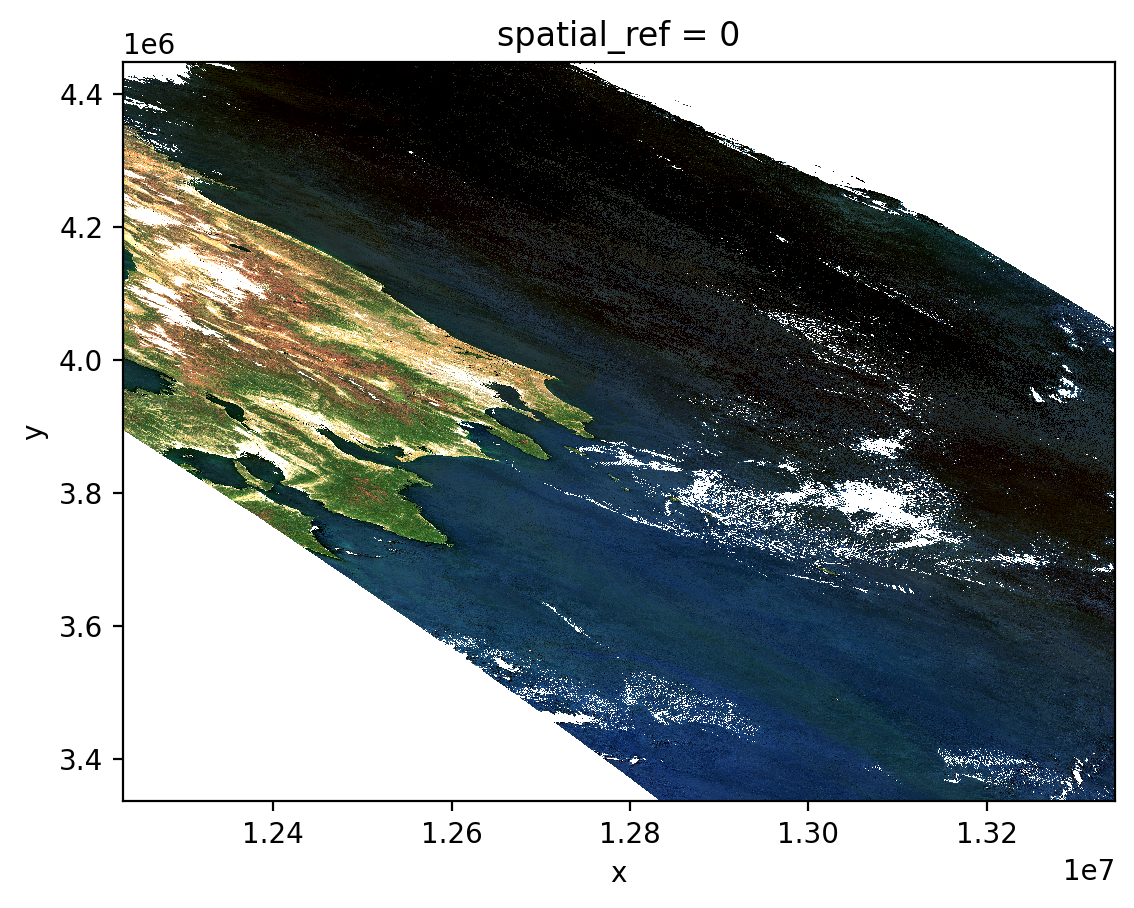

In [22]:
rsrf.plot.imshow(rgb="band", robust=True)

The projection for GCOM-C L2 Tile is EQA (sinusoidal equal area).

In [23]:
rsrf.rio.crs.to_string()

'ESRI:53008'

Reproject the data to `EPSG:4326` and plot it again.

Text(0.5, 1.0, 'GC1SG1_20230413D01D_T0529_L2SG_RSRFQ_3002')

/Users/sankichi92/Library/Caches/pypoetry/virtualenvs/gportal-VRisJ_BE-py3.11/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


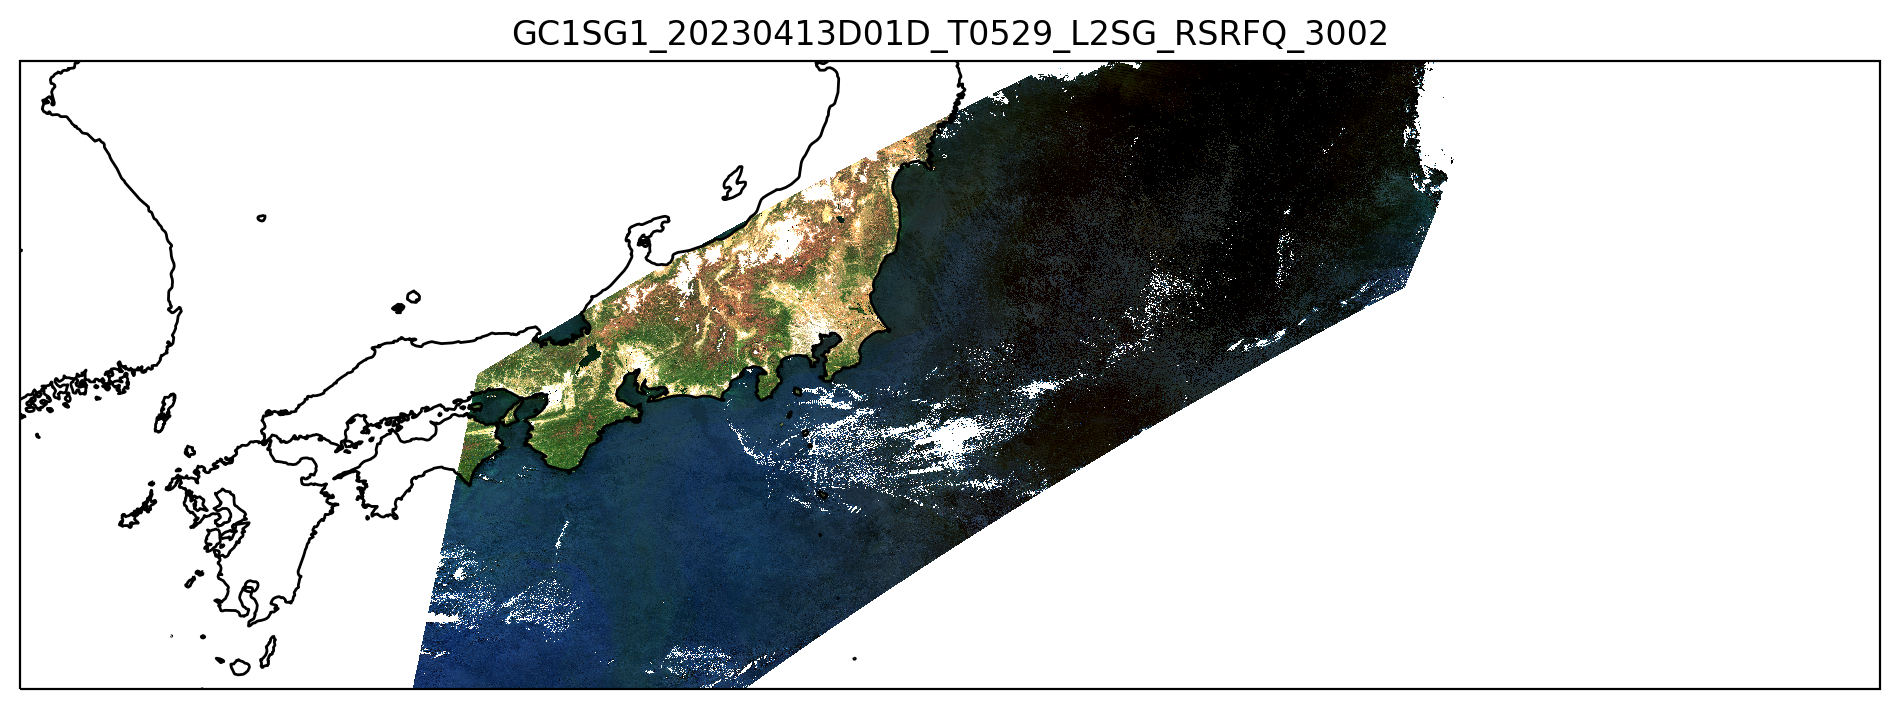

In [24]:
reprojected_rsrf = rsrf.rio.reproject("EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
reprojected_rsrf.plot.imshow(ax=ax, rgb="band", robust=True)
ax.set_title(rsrf_file.granule_id)